In [ ]:
# Check The Data
class_list = fruit_class.values()
for cls in class_list:
    for i, filename in enumerate(os.listdir(data_path + cls)):
        try:
            img = Image.open(data_path + cls + '/' + filename)
        except:
            print(filename)

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split

from PIL import Image

%matplotlib inline

In [2]:
def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    datasets = {}
    datasets['train'] = torch.utils.data.Subset(dataset, train_idx)
    datasets['test'] = torch.utils.data.Subset(dataset, test_idx)
    
    return datasets

data_path = '../../data/fruit/'
fruit_class = {0:'banana', 1:'grape', 2:'orange', 3:'strawberry', 5:'apple', 6:'pineapple', 7:'unknown'}
print(os.listdir(data_path))

['apple', 'banana', 'grape', 'orange', 'pineapple', 'strawberry', 'unknown']


In [3]:
# Parameters
EPOCH = 80
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 4
TEST_SIZE = 0.20
LEARNING_RATE = 0.001
MOMENTUM = 0.9
CLASS_NUM = len(os.listdir(data_path))

In [4]:
transform = transforms.Compose([
    transforms.Resize((200,200)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomAffine(30),
    transforms.ColorJitter(contrast=(0.2, 3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

dataset = torchvision.datasets.ImageFolder(root=data_path, transform=transform)
datasets = train_test_dataset(dataset, test_split=TEST_SIZE)

trainloader = torch.utils.data.DataLoader(datasets['train'], batch_size=TRAIN_BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(datasets['test'], batch_size=TEST_BATCH_SIZE, shuffle=True)

print(len(trainloader))
print(len(testloader))

213
426


tensor([3, 2, 2, 3, 2, 0, 3, 3, 0, 2, 6, 5, 1, 3, 1, 3, 1, 5, 4, 2, 5, 2, 1, 1,
        5, 4, 4, 4, 4, 3, 4, 4])


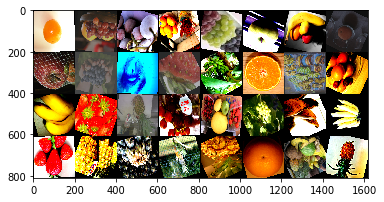

In [5]:
#image show
from torchvision.utils import make_grid

ex_img, ex_label = iter(trainloader).next()
for i, im in enumerate(ex_img):
    ex_img[i] = inv_normalize(ex_img[i])
img_grid = make_grid(ex_img).permute(1,2,0)
plt.imshow(img_grid)
print(ex_label)

In [6]:
# Models
model_vgg16 = torchvision.models.vgg16(pretrained=True)

for p in model_vgg16.features.parameters():
    p.requires_grad = False
    
model_vgg16.classifier[6] = nn.Linear(4096, CLASS_NUM)

    
model_vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=7, bias=True)
)

In [7]:
# GPU 여부
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('We are using GPU')
else:
    device = torch.device('cpu')
    print('We are using CPU')

We are using GPU


In [8]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg16.parameters(), lr=0.002, momentum=0.9)

In [9]:
# Model Test
with torch.no_grad():
    model_vgg16.eval()
    model_vgg16.to(device)
    ex_img, ex_label = iter(trainloader).next()
    ex_img, ex_label = ex_img.to(device), ex_label.to(device)
    print(ex_img.size())
    ex_output = model_vgg16(ex_img)
    print(ex_output.max(1))

torch.Size([32, 3, 200, 200])
torch.return_types.max(
values=tensor([0.2554, 0.7749, 0.2759, 0.1530, 0.3041, 0.4725, 0.0032, 0.4581, 0.1006,
        0.6045, 0.6853, 0.1844, 0.6829, 0.3645, 0.2280, 0.3343, 0.1718, 0.2623,
        0.5823, 0.4742, 0.4736, 0.5298, 0.6163, 0.5032, 0.5061, 0.1422, 0.5792,
        0.3287, 0.8611, 0.2046, 0.3641, 0.3905], device='cuda:0'),
indices=tensor([3, 3, 6, 1, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 0,
        2, 3, 3, 3, 5, 5, 1, 3], device='cuda:0'))


In [10]:
# Model Traing
import time
import datetime

for e in range(EPOCH):
    model_vgg16.train()
    model_vgg16.to(device)
    start_time = time.time()
    running_loss = 0
    
    for i, data in enumerate(trainloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        
        optimizer.zero_grad()
        outputs = model_vgg16(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss
        now = time.time()
        print('\r[%d/%d]-----[%d/%d] LOSS : %.3f------ Time : %d' 
              %(e+1, EPOCH, i+1, len(trainloader), running_loss, now - start_time), end = '')
    if e==0:
        running_time = now-start_time
        print('\n')
        print(datetime.timedelta(seconds=running_time*EPOCH))

[1/80]-----[213/213] LOSS : 173.912------ Time : 45

1:00:39.724503
[80/80]-----[213/213] LOSS : 9.180------ Time : 444

In [11]:
correct = 0
total = 0
model_vgg16.eval()

with torch.no_grad():
    model_vgg16.to(device)
    for i, data in enumerate(testloader):
        test_images, test_labels = data
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        
        test_outputs = model_vgg16(test_images)
        pred = test_outputs.argmax(dim=1, keepdim=True)
        total += pred.size()[0]
        correct += pred.eq(test_labels.view_as(pred)).sum().item()

acc = correct / total * 100
print('The Accuracy of Model is %0.2f%%' % (correct / total * 100))

The Accuracy of Model is 85.50%


In [13]:
# Save Model
torch.save(model_vgg16.cpu().state_dict(), os.getcwd() + '/models/trained_model_epoch{}_acc{}_class{}.pth'.format(EPOCH, acc, CLASS_NUM))

KeyError: 4

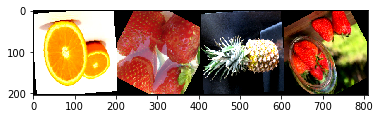

In [14]:
model_vgg16.eval()
with torch.no_grad():
    ex_img, ex_label = iter(testloader).next()
    model_vgg16.to(device)
    ex_img = ex_img.to(device)
    output = model_vgg16(ex_img)

ex_pred = output.argmax(dim=1)
for i, im in enumerate(ex_img):
    ex_img[i] = inv_normalize(ex_img[i])
plt.imshow(make_grid(ex_img).permute(1,2,0).cpu())
print('GroundTruth : ', ' '.join(fruit_class[ex_label[j].item()] for j in range(4)))
print('Predicted : ', ' '.join(fruit_class[ex_pred[i].item()] for i in range(4)))